In [6]:
import json
import numpy as np
import matplotlib.pyplot as plt

First experiment, comparing all splitting heuristics.
First I generated 10 random seeds which will be used for each experiment.

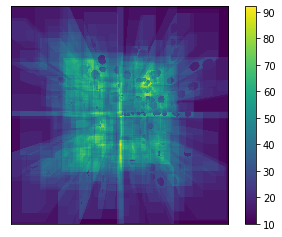

In [7]:
with open("../renders/intersection_tests.txt", "r") as file:
    counts = list(map(int, file.read().split(",")))
    counts = [counts[i:i+640] for i in range(0, len(counts), 640)]
    fig = plt.imshow(counts, origin="lower", interpolation="none")
    plt.colorbar(fig)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
#     plt.savefig("renders/intersection_count.png")

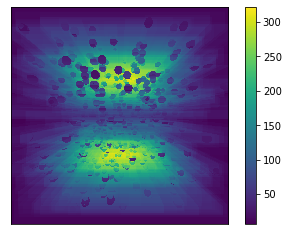

In [6]:
with open("../renders/intersection_tests.txt", "r") as file:
    counts = list(map(int, file.read().split(",")))
    counts = [counts[i:i+640] for i in range(0, len(counts), 640)]
    fig = plt.imshow(counts, origin="lower", interpolation="none")
    plt.colorbar(fig)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
#     plt.savefig("renders/intersection_count.png")

[336459.27056096 263590.72325072 240926.81919297 211425.26200045
 237011.7958862  180478.97266319 179329.65906687  82242.79059231
 200939.9531681  166404.46362478 115128.07475855 124015.81593414
  93680.47481498 133354.24914475 125665.20006844]
[292990.74284619 226638.55125342 198937.51233794 165819.78135687
 184690.33621457 159418.29757076 177017.97117878 113133.6182079
 211619.4711743  179499.82333554 133168.72069105  90322.52078994
  79332.17123967  76003.4329222   96012.44554541]
[299354.59629879 204490.08508101 166774.4331383  167136.73625152
 160588.5310214  149829.78601053 149150.64217042 100376.00124437
 209924.27672485 178466.71952723 136474.39836281  85916.93343858
  83786.1423273   86090.65103535  97071.10381164]


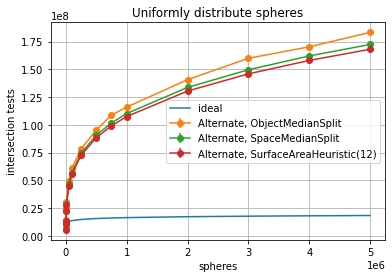

In [20]:
with open("results/splitting_heuristics_equal_spheres_uniform_position.json") as f:
    data = json.load(f)
    
    nb_spheres = np.array(data['nb_objects'])
    
    fig, ax = plt.subplots()
    ax.set_yscale('linear')
    ax.set_xscale('linear')
    ax.set(xlabel='spheres', ylabel='intersection tests',title='Uniformly distribute spheres')
    
    ideal = 640 * 640 * 2 * np.log2(nb_spheres)
    ax.plot(nb_spheres, ideal, label='ideal')
        
    for (splitting_heuristic, intersection_tests) in sorted(data['results'].items()):        
        if "Alternate" not in splitting_heuristic:
            continue

        results = [np.array(k) for k in intersection_tests]
        averages = np.array([np.average(res) for res in results])
        stds = np.array([np.std(res) for res in results])
        
        ax.errorbar(nb_spheres, averages, yerr=stds, fmt='-o', label=splitting_heuristic)
        
    ax.grid(True)
    ax.legend()
    plt.savefig('results/plots/compare_splitting_heuristics2.png')

From here on a new json format was used

[  615693.70060641   916587.83424495   917363.51298994  1913761.31315319
  2599443.01506492  4739919.73112826  6704721.32040537  4326342.24928406
 11480612.80553276 16792246.42159161 17147058.2611518  21797046.60233816
 19862609.9182761  26699305.44949258 23214531.0205866 ]
[ 309666.68089326  295653.92527049  130601.28178161  292974.29572432
  377527.47858598  585030.90103249  879721.59847273 1317122.5093055
 1244288.08213468 1377412.05584001 1237908.04228691 2685189.51095573
 3845676.76661367 3354466.12456916 3164850.91631122]
[ 344300.79986722  271789.40283749   95253.15174549  288104.38030485
  392785.28816529  580701.62751592  849022.25371457 1279850.43963285
 1222796.6418826  1340470.83543994 1207708.10656592 2599517.13018162
 3728636.88135916 3264971.05494351 3079694.676072  ]


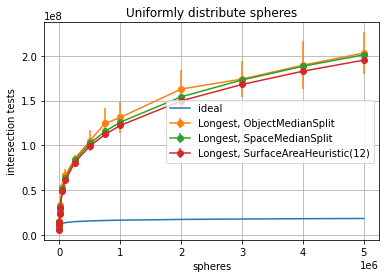

In [22]:
with open("results/splitting_heuristics_equal_spheres_uniform_position.json") as f:
    data = json.load(f)
    
    nb_spheres = np.array(data['nb_objects'])
    
    fig, ax = plt.subplots()
    ax.set_yscale('linear')
    ax.set_xscale('linear')
    ax.set(xlabel='spheres', ylabel='intersection tests',title='Uniformly distribute spheres')
    
    ideal = 640 * 640 * 2 * np.log2(nb_spheres)
    ax.plot(nb_spheres, ideal, label='ideal')
        
    for (splitting_heuristic, intersection_tests) in sorted(data['results'].items()):        
        if "Alternate" in splitting_heuristic:
            continue

        results = [np.array(k) for k in intersection_tests]
        averages = np.array([np.average(res) for res in results])
        stds = np.array([np.std(res) for res in results])
    
        print(stds)

        
        ax.errorbar(nb_spheres, averages, yerr=stds, fmt='-o', label=splitting_heuristic)
        
    ax.grid(True)
    ax.legend()
#     plt.savefig('results/plots/compare_splitting_heuristics2.png')


In [ ]:
with open("results/instanced_intersections.json") as instanced, open("results/flattened_intersections.json") as flattened:
    data = json.load(f)
    
    nb_spheres = np.array(data['nb_objects'])
    
    fig, ax = plt.subplots()
    ax.set_yscale('linear')
    ax.set_xscale('linear')
    ax.set(xlabel='spheres', ylabel='intersection tests',title='Uniformly distribute spheres')
    
    ideal = 640 * 640 * 2 * np.log2(nb_spheres)
    ax.plot(nb_spheres, ideal, label='ideal')
        
    for (splitting_heuristic, intersection_tests) in sorted(data['results'].items()):        
        if "Alternate" in splitting_heuristic:
            continue

        results = [np.array(k) for k in intersection_tests]
        averages = np.array([np.average(res) for res in results])
        stds = np.array([np.std(res) for res in results])
    
        print(stds)

        
        ax.errorbar(nb_spheres, averages, yerr=stds, fmt='-o', label=splitting_heuristic)
        
    ax.grid(True)
    ax.legend()
#     plt.savefig('results/plots/compare_splitting_heuristics2.png')

